Loading test data from: C:\kanno\vscode\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\data\HAR_pose_activities\database\X_test.txt
Loading test labels from: C:\kanno\vscode\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\data\HAR_pose_activities\database\Y_test.txt
INFO:tensorflow:Restoring parameters from C:\kanno\vscode\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\weights\model.ckpt
Model restored from file: C:\kanno\vscode\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\weights\model.ckpt

--- Evaluation Results ---
Testing Accuracy: 95.00%

Precision: 95.83%
Recall: 95.00%
f1_score: 94.95%

Confusion Matrix:
Created using test set of 40 datapoints


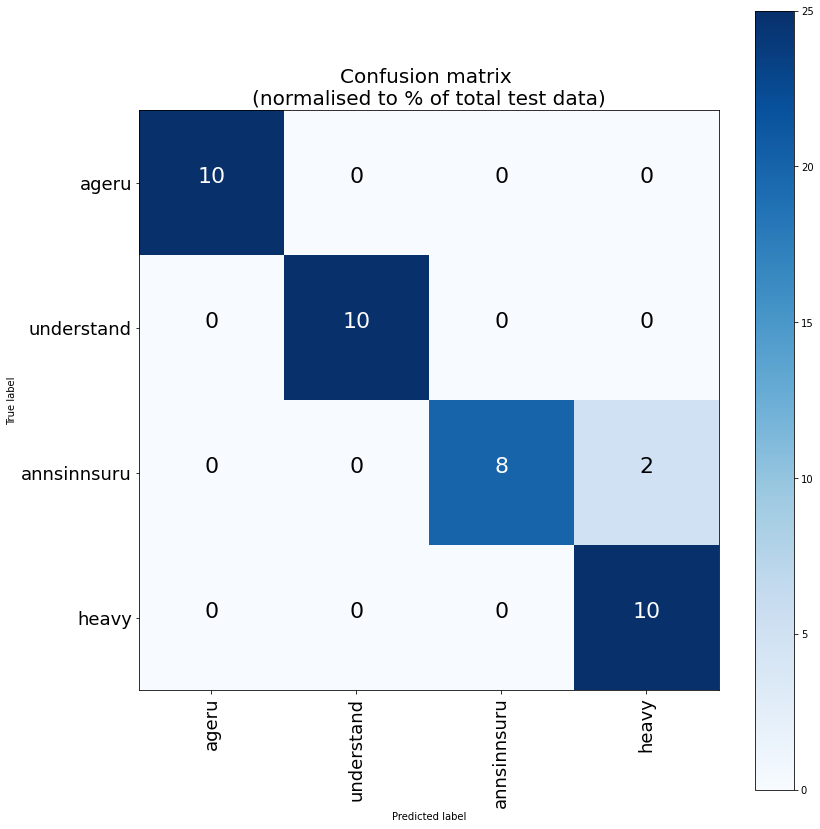

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import itertools
import argparse # ★★★ コマンドライン引数を扱うために追加 ★★★

# TensorFlow 1.x系のグラフをリセット
tf.reset_default_graph()

# --- モデルの基本設定 (train.pyと完全に同じにする必要があります) ---
LABELS = [
    "ageru",
    "understand",
    "annsinnsuru",
    "heavy"
]
n_steps = 30
n_hidden = 30
n_classes = 4

X_TEST_PATH = r"C:\kanno\vscode\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\data\HAR_pose_activities\database\X_test.txt"
Y_TEST_PATH = r"C:\kanno\vscode\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\data\HAR_pose_activities\database\Y_test.txt"

# ★★★ 保存されたモデルが格納されているパス ★★★
MODEL_PATH = r"C:\kanno\vscode\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\weights\model.ckpt"

# --- データ読み込み関数 (train.pyと同じものをコピー) ---
def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]],
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    X_ = np.array(np.split(X_, blocks))
    return X_

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    return y_ - 1

def one_hot(y_):
    y_ = y_.reshape(len(y_))
    n_values = n_classes
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]

# --- メインの処理 ---
if __name__ == '__main__':
    # # ★★★ コマンドライン引数の設定 ★★★
    # parser = argparse.ArgumentParser(description='Evaluate a trained model.')
    # parser.add_argument('--x_path', type=str, required=True, help='Path to the test data file (X_test.txt or other).')
    # parser.add_argument('--y_path', type=str, required=True, help='Path to the test label file (Y_test.txt or other).')
    # args = parser.parse_args()

    # --- 引数で指定されたテストデータを読み込む ---
    print(f"Loading test data from: {X_TEST_PATH}")
    print(f"Loading test labels from: {Y_TEST_PATH}")
    X_test = load_X(X_TEST_PATH)
    y_test = load_y(Y_TEST_PATH)
    
    # n_inputはデータから決定する必要がある
    n_input = len(X_test[0][0])
    
    # --- TensorFlowグラフ構築 (train.pyと全く同じ構造) ---
    # ここには学習関連の処理（optimizer, lossなど）は不要。推論に必要な部分だけを定義する。
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])
    # weights = {
    #     'hidden': tf.Variable(tf.zeros([n_input, n_hidden])), # 初期値はゼロでOK（後で読み込むため）
    #     'out': tf.Variable(tf.zeros([n_hidden, n_classes]))
    # }
    # biases = {
    #     'hidden': tf.Variable(tf.zeros([n_hidden])),
    #     'out': tf.Variable(tf.zeros([n_classes]))
    # }
    weights = {
    'hidden': tf.Variable(tf.zeros([n_input, n_hidden]), name="weights_hidden"),
    'out': tf.Variable(tf.zeros([n_hidden, n_classes]), name="weights_out")
    }
    biases = {
    'hidden': tf.Variable(tf.zeros([n_hidden]), name="biases_hidden"),
    'out': tf.Variable(tf.zeros([n_classes]), name="biases_out")
    }
    # LSTMモデルの定義 (train.pyと同じ関数)
    def LSTM_RNN(_X, _weights, _biases):
        _X = tf.transpose(_X, [1, 0, 2])
        _X = tf.reshape(_X, [-1, n_input])
        # _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
        _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
        _X = tf.split(_X, n_steps, 0)
        lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
        lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
        lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
        outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)
        lstm_last_output = outputs[-1]
        return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

    pred = LSTM_RNN(x, weights, biases)
    
    # 評価指標の定義
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # ★★★ モデルを復元するためのSaverオブジェクトを作成 ★★★
    saver = tf.train.Saver()
    
    # --- セッションを開始し、モデルを読み込んで評価を実行 ---
    with tf.Session() as sess:
        # tf.global_variables_initializer() は実行しない！
        # 代わりに、保存したモデルの重みを復元する
        saver.restore(sess, MODEL_PATH)
        print("Model restored from file:", MODEL_PATH)

        # 読み込んだモデルで予測と評価を行う
        one_hot_predictions, test_accuracy = sess.run(
            [pred, accuracy],
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )

        print("\n--- Evaluation Results ---")
        print("Testing Accuracy: {:.2f}%".format(100 * test_accuracy))

        predictions = one_hot_predictions.argmax(1)

        print("")
        print("Precision: {:.2f}%".format(100 * metrics.precision_score(y_test, predictions, average="weighted")))
        print("Recall: {:.2f}%".format(100 * metrics.recall_score(y_test, predictions, average="weighted")))
        print("f1_score: {:.2f}%".format(100 * metrics.f1_score(y_test, predictions, average="weighted")))
        
        print("")
        print("Confusion Matrix:")
        print("Created using test set of {} datapoints".format(len(y_test)))
        confusion_matrix = metrics.confusion_matrix(y_test, predictions)

        # 混同行列の正規化とプロット
        normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32) / np.sum(confusion_matrix) * 100

        width = 12
        height = 12
        plt.figure(figsize=(width, height))
        plt.imshow(normalised_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix \n(normalised to % of total test data)", fontsize=20)
        plt.colorbar()
        tick_marks = np.arange(n_classes)
        plt.xticks(tick_marks, LABELS, rotation=90, fontsize=18)
        plt.yticks(tick_marks, LABELS, fontsize=18)
        
        thresh = normalised_confusion_matrix.max() / 2.
        for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
            plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if normalised_confusion_matrix[i, j] > thresh else "black",fontsize=22)
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()